# MNIST Demo
___

### Load package
Also remember to start your Julia session with multiple threads to speed up learning. Here I'm using 4.

In [1]:
using Alice

In [2]:
Base.Threads.nthreads()

4

### Load the data

The MNIST database is a collection of handwritten digits and labels from a larger collection originally created by NIST (National Institute of Standards and Technology). It contains characters written by American Census bereau employees and high school students.

The common set that everyone uses now for ML testing was created by Yan LeCun (http://yann.lecun.com/exdb/mnist/). And there is a Julia package that makes it easy to access the data.

In [3]:
using MNIST

#### Visualising the data

In [4]:
function display_mnist(; flipink = false)
    rows, cols = 16, 32
    num_images = rows * cols
    selection = rand(1:60000, num_images)            # Random selection of image indices
    images = Array(Array{Float64, 2}, 0)             # Initialise blank outer array to contain image arrays
    img = ones(30, 30)                               # Create blank canvas with some padding
    for i in selection
        img[2:29, 2:29] = trainfeatures(i) ./ 255    # Reshape each image as a matrix and place in canvas
        push!(images, copy(img))                     # Push single image into images vector
    end
    images = hvcat(cols, images...)                  # Concatenate individual image matrices into a large matrix
    
    # Display image with either white or black ink with opposite background
    flipink ? Gray.(1.0 - images) : Gray.(images)
end;

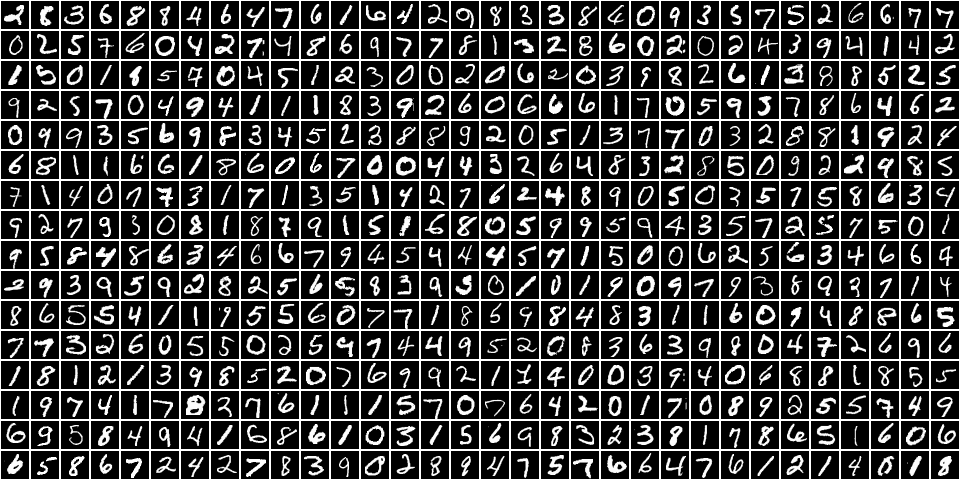

In [5]:
display_mnist()

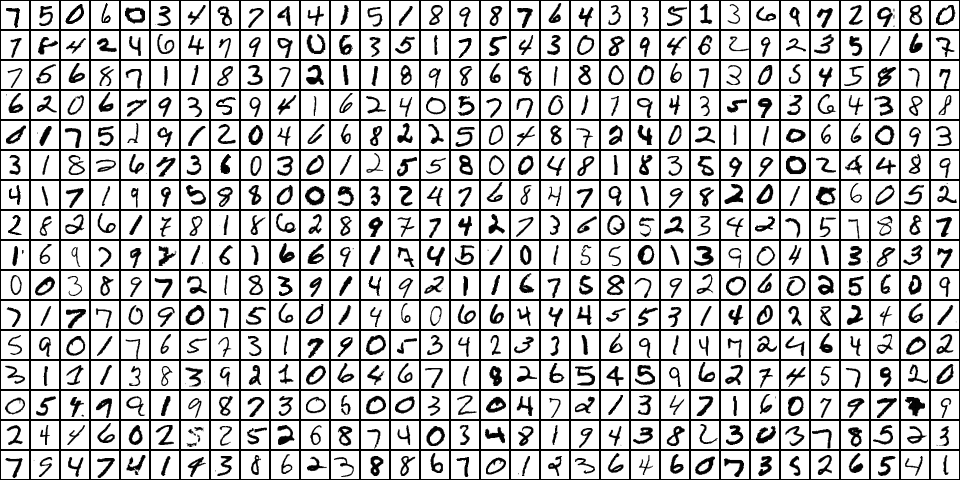

In [6]:
display_mnist(flipink = true)

#### Training, validation and test data sets
The original data has two separate sets - 60,000 training and 10,000 test observations. Here we'll train on the first 50,000 in the original training set and use the other 10,000 for cross validation. The test set can stay as it is.

The only pre-processing will be to scale the pixel inputs to the range [0, 1], reshape each image into a 28x28 array (in the provided set each image is a single column), and change the output label 0 to 10.

In [7]:
# Download training images and labels from MNIST package
train_images, train_labels = traindata()
test_images, test_labels = testdata()

# Rescale and reshape
train_images = train_images ./ 255
train_images = reshape(train_images, 28, 28, 60000)
test_images = test_images ./ 255
test_images = reshape(test_images, 28, 28, 10000)

# Convert target to integer (from float) type and swap label 0 for 10
train_labels = Int.(train_labels)
train_labels[train_labels .== 0] = 10
test_labels = Int.(test_labels)
test_labels[test_labels .== 0] = 10

# Split training set into 50,000 training and 10,000 validation images

# Images
val_images = train_images[:, :, 50001:60000]
train_images = train_images[:, :, 1:50000]

# Labels
val_labels = train_labels[50001:60000]
train_labels = train_labels[1:50000];

### Build and train models

#### Net 1 - Shallow and narrow feed forward neural network
Let's get a benchmark result with a feedforward neural network (only fully connected hidden layers) with 2 hidden layers each with 50 neurons.

In [8]:
# Set seed to be able to replicate
srand(123)

# Data Box and Input Layer
databox = Data(train_images, train_labels, val_images, val_labels)
batch_size = 128
input = InputLayer(databox, batch_size)

# Fully connected hidden layers
dim = 30
fc1 = FullyConnectedLayer(size(input), dim, activation = :tanh)
fc2 = FullyConnectedLayer(size(fc1), dim, activation = :tanh)

# Softmax Output Layer
dim_in = 30
num_classes = 10
output = SoftmaxOutputLayer(databox, size(fc2), num_classes)

# Model
λ = 1e-3    # Regularisation
net = NeuralNet(databox, [input, fc1, fc2, output], λ, regularisation=:L2)

Neural Network
Training Data Dimensions - (28,28,50000)
Layers:
Layer 1 - Alice.InputLayer{Float64}, Dimensions - (28,28,128)
Layer 2 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.tanh, Dimensions - (30,128)
Layer 3 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.tanh, Dimensions - (30,128)
Layer 4 - Alice.SoftmaxOutputLayer{Float64,Int64}, Dimensions - (10,128)


In [9]:
check_gradients(net)

LoadError: UndefVarError: check_gradients not defined

In [10]:
# Training parameters
num_epochs = 40    # number of epochs
α = 1e-2           # learning rate
μ = 0.9            # momentum param / viscosity

# Train
train(net, num_epochs, α, μ, nesterov=true, shuffle=true, last_train_every=2, full_train_every=10, val_every=10)

14:16:07 : Epoch 2, last batch training error (with regⁿ) - 0.386
14:16:09 : Epoch 4, last batch training error (with regⁿ) - 0.267
14:16:11 : Epoch 6, last batch training error (with regⁿ) - 0.289
14:16:12 : Epoch 8, last batch training error (with regⁿ) - 0.319
14:16:17 : Epoch 10, last batch training error (with regⁿ) - 0.219

Coffee break:
Training error (with regⁿ) - 0.213  |  Training accuracy - 96.6
Validation error (without regⁿ) - 0.135  |  Validation accuracy - 96.5

14:16:19 : Epoch 12, last batch training error (with regⁿ) - 0.338
14:16:21 : Epoch 14, last batch training error (with regⁿ) - 0.214
14:16:22 : Epoch 16, last batch training error (with regⁿ) - 0.261
14:16:24 : Epoch 18, last batch training error (with regⁿ) - 0.160
14:16:26 : Epoch 20, last batch training error (with regⁿ) - 0.226

Coffee break:
Training error (with regⁿ) - 0.181  |  Training accuracy - 97.7
Validation error (without regⁿ) - 0.116  |  Validation accuracy - 96.8

14:16:28 : Epoch 22, last batch 

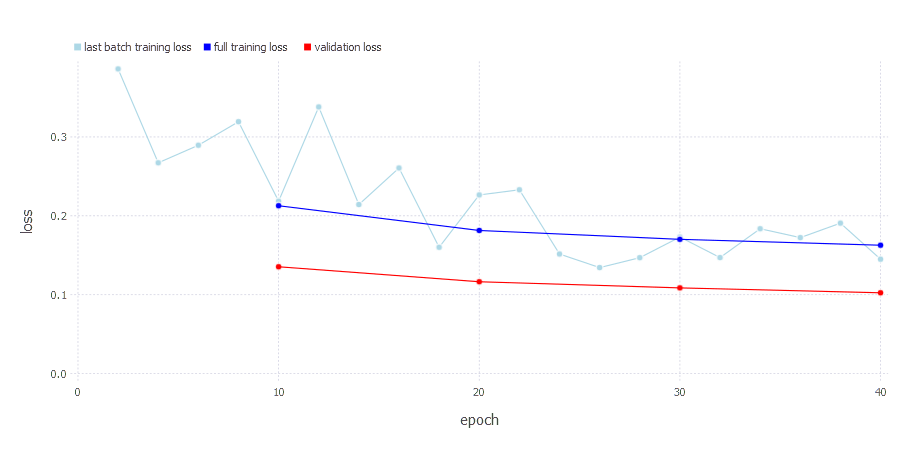

In [11]:
# PLot loss curves
Gadfly.set_default_plot_size(24cm, 12cm)
plot_loss_history(net, 2, 10, 10)

#### Net 2 - Convolutional neural network
Next let's train a convolutional neural network with configuration:  
input -> convolution layer -> max pool layer -> fully connected layer -> softmax output layer

In [8]:
# Set seed to be able to replicate
srand(123)

# Data Box and Input Layer
databox = Data(train_images, train_labels, val_images, val_labels, test_images, test_labels)
batch_size = 128
input = InputLayer(databox, batch_size)

# Convolution Layer
patch_dim = 5
num_patches = 20
patch_dims = (patch_dim, patch_dim, num_patches)
conv1 = ConvolutionLayer(size(input), patch_dims, activation = :relu)

# Pooling Layer
stride = 2
pool1 = MaxPoolLayer(size(conv1), stride)

# Fully Connected Layer
dim = 100
fc1 = FullyConnectedLayer(size(pool1), dim, activation = :relu)

# Softmax Output Layer
num_classes = 10
output = SoftmaxOutputLayer(databox, size(fc1), num_classes)

# Model
λ = 1e-3    # Regularisation
net = NeuralNet(databox, [input, conv1, pool1, fc1, output], λ, regularisation=:L2)

Neural Network
Training Data Dimensions - (28,28,50000)
Layers:
Layer 1 - InputLayer{Float64}, Dimensions - (28,28,128)
Layer 2 - ConvolutionLayer{Float64}, Activation - relu, Dimensions - (24,24,20,128)
Layer 3 - MaxPoolLayer{Float64,Int64}, Dimensions - (12,12,20,128)
Layer 4 - FullyConnectedLayer{Float64}, Activation - relu, Dimensions - (100,128)
Layer 5 - SoftmaxOutputLayer{Float64,Int64}, Dimensions - (10,128)


In [13]:
# Training parameters
num_epochs = 40    # number of epochs
α = 1e-2           # learning rate
μ = 0.9            # momentum param / viscosity

# Training
train(net, num_epochs, α, μ, nesterov=true, shuffle=true, last_train_every=2, full_train_every=10, val_every=10)

15:44:35 : Epoch 2, last batch training error (with regⁿ) - 0.252
15:45:35 : Epoch 4, last batch training error (with regⁿ) - 0.181
15:46:35 : Epoch 6, last batch training error (with regⁿ) - 0.204
15:47:35 : Epoch 8, last batch training error (with regⁿ) - 0.146
15:48:37 : Epoch 10, last batch training error (with regⁿ) - 0.170

Coffee break:
Training error (with regⁿ) - 0.124  |  Training accuracy - 99.1
Validation error (without regⁿ) - 0.052  |  Validation accuracy - 98.5

15:49:51 : Epoch 12, last batch training error (with regⁿ) - 0.092
15:50:50 : Epoch 14, last batch training error (with regⁿ) - 0.145
15:51:49 : Epoch 16, last batch training error (with regⁿ) - 0.115
15:52:49 : Epoch 18, last batch training error (with regⁿ) - 0.100
15:53:46 : Epoch 20, last batch training error (with regⁿ) - 0.088

Coffee break:
Training error (with regⁿ) - 0.088  |  Training accuracy - 99.6
Validation error (without regⁿ) - 0.045  |  Validation accuracy - 98.7

15:55:01 : Epoch 22, last batch 

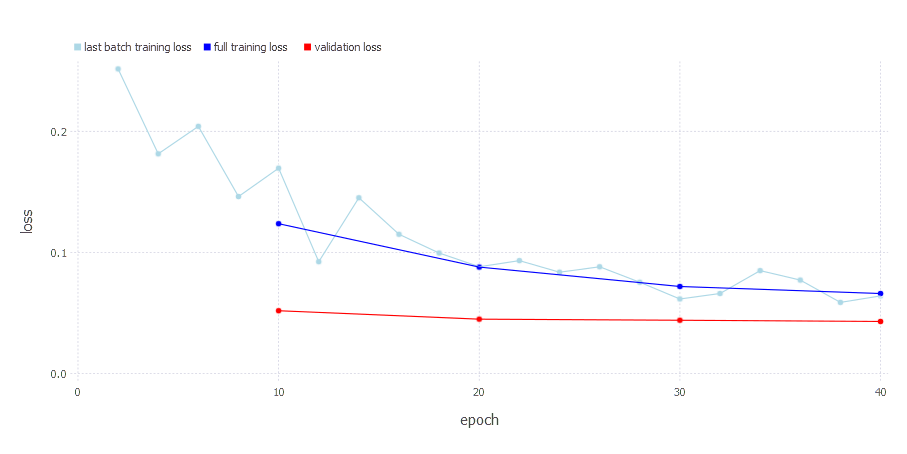

In [14]:
plot_loss_history(net, 2, 10, 10)

#### Net 3 - Deeper convolutional neural network
Next let's train a deeper convolutional neural network with configuration:  
input -> convolution layer -> max pool layer -> convolution layer -> max pool layer -> fully connected layer -> softmax output layer

In [34]:
# Set seed to be able to replicate
srand(123)

# Data Box and Input Layer
databox = Data(train_images, train_labels, val_images, val_labels, test_images, test_labels)
batch_size = 128
input = InputLayer(databox, batch_size)

# Convolution Layer 1
patch_dim = 5
num_patches1 = 20
patch_dims = (patch_dim, patch_dim, num_patches1)
conv1 = ConvolutionLayer(size(input), patch_dims, activation = :relu)

# Pooling Layer 1
stride = 2
pool1 = MaxPoolLayer(size(conv1), stride)

# Convolution Layer 2
patch_dim = 5
num_patches2 = 40
patch_dims = (patch_dim, patch_dim, num_patches1, num_patches2)
conv2 = ConvolutionLayer(size(pool1), patch_dims, activation = :relu)

# Pooling Layer 2
stride = 2
pool2 = MaxPoolLayer(size(conv2), stride)

# Fully Connected Layer
dim = 100
fc1 = FullyConnectedLayer(size(pool2), dim, activation = :relu)

# Softmax Output Layer
num_classes = 10
output = SoftmaxOutputLayer(databox, size(fc1), num_classes)

# Model
λ = 1e-3    # Regularisation
net = NeuralNet(databox, [input, conv1, pool1, conv2, pool2, fc1, output], λ, regularisation=:L2)

Neural Network
Training Data Dimensions - (28,28,50000)
Layers:
Layer 1 - InputLayer{Float64}, Dimensions - (28,28,128)
Layer 2 - ConvolutionLayer{Float64}, Activation - relu, Dimensions - (24,24,20,128)
Layer 3 - MaxPoolLayer{Float64,Int64}, Dimensions - (12,12,20,128)
Layer 4 - ConvolutionLayer{Float64}, Activation - relu, Dimensions - (8,8,40,128)
Layer 5 - MaxPoolLayer{Float64,Int64}, Dimensions - (4,4,40,128)
Layer 6 - FullyConnectedLayer{Float64}, Activation - relu, Dimensions - (100,128)
Layer 7 - SoftmaxOutputLayer{Float64,Int64}, Dimensions - (10,128)


In [24]:
#check_gradients(net)

In [35]:
# Training parameters
num_epochs = 40    # number of epochs
α = 1e-2           # learning rate
μ = 0.9            # momentum param / viscosity

# Training
train(net, num_epochs, α, μ, nesterov=true, shuffle=true, last_train_every=2, full_train_every=10, val_every=10)

23:07:37 : Epoch 2, last batch training error (with regⁿ) - 0.241
23:12:35 : Epoch 4, last batch training error (with regⁿ) - 0.170
23:17:33 : Epoch 6, last batch training error (with regⁿ) - 0.155
23:22:30 : Epoch 8, last batch training error (with regⁿ) - 0.139
23:27:27 : Epoch 10, last batch training error (with regⁿ) - 0.179

Coffee break:
Training error (with regⁿ) - 0.142  |  Training accuracy - 99.0
Validation error (without regⁿ) - 0.049  |  Validation accuracy - 98.5

23:33:12 : Epoch 12, last batch training error (with regⁿ) - 0.121
23:38:08 : Epoch 14, last batch training error (with regⁿ) - 0.118
23:43:04 : Epoch 16, last batch training error (with regⁿ) - 0.104
23:48:01 : Epoch 18, last batch training error (with regⁿ) - 0.109
23:52:57 : Epoch 20, last batch training error (with regⁿ) - 0.118

Coffee break:
Training error (with regⁿ) - 0.104  |  Training accuracy - 99.3
Validation error (without regⁿ) - 0.043  |  Validation accuracy - 98.9

23:58:43 : Epoch 22, last batch 

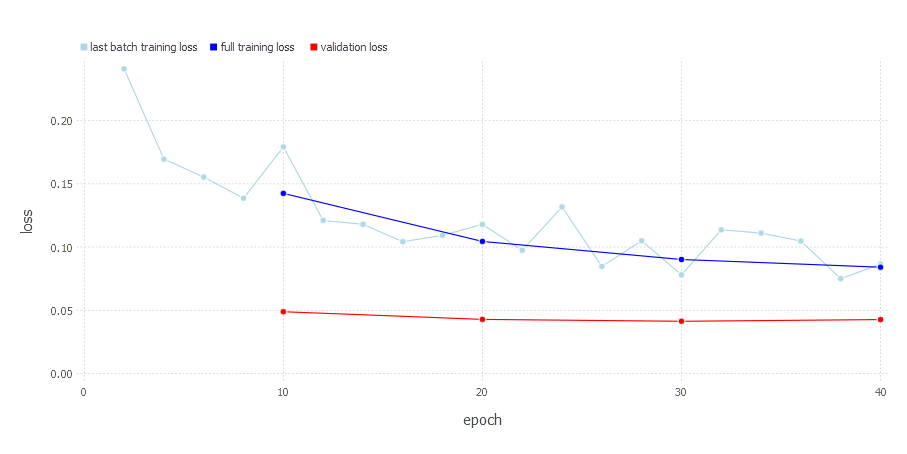

In [36]:
Gadfly.set_default_plot_size(24cm, 12cm)
plot_loss_history(net, 2, 10, 10)

### Best test set accuracy

In [75]:
accuracy(net, test_images, test_labels)

98.42748397435898